## Load features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

DATA_PATH = "../data/feature_table.parquet"

df_model = pd.read_parquet(DATA_PATH).sort_values("date").reset_index(drop=True)
df_model.head()

,date,kpi_value,promo_index,baseline_trend,seasonality,is_anomaly,dow,month,day,is_weekend,kpi_value_lag_1,kpi_value_lag_7,kpi_value_lag_14,kpi_value_roll_mean_7,kpi_value_roll_std_7,kpi_value_roll_mean_14,kpi_value_roll_std_14,kpi_value_roll_mean_28,kpi_value_roll_std_28,promo_flag
0,2016-01-29,43.231120,0.0,50.84028,-5.206605,0,4,1,29,0,57.519667,44.520500,38.313864,49.124953,9.834182,48.720285,9.891477,50.839428,9.991112,0
1,2016-01-30,38.004380,0.0,50.87029,-11.699135,0,5,1,30,1,43.231120,39.231198,36.501865,48.940756,9.946236,49.071518,9.575801,50.712673,10.066744,0
2,2016-01-31,39.111496,0.0,50.90030,-9.381978,0,6,1,31,1,38.004380,35.609260,37.046858,48.765496,10.154469,49.178840,9.431419,50.236043,10.347474,0
3,2016-02-01,58.339423,0.0,50.93031,0.000000,0,0,2,1,0,39.111496,48.542709,51.767159,49.265816,9.460799,49.326314,9.241352,50.087568,10.480125,0
4,2016-02-02,60.288309,0.0,50.96032,9.381978,0,1,2,2,0,58.339423,60.575918,56.290062,50.665346,10.042717,49.795762,9.537080,49.536175,9.552610,0


## Train/test split (time-based)

In [2]:
target = "kpi_value"
drop_cols = ["date", target, "is_anomaly"] if "is_anomaly" in df_model.columns else ["date", target]
X_cols = [c for c in df_model.columns if c not in drop_cols]

# last 20% as test
split_idx = int(len(df_model) * 0.8)
train = df_model.iloc[:split_idx].copy()
test  = df_model.iloc[split_idx:].copy()

X_train, y_train = train[X_cols], train[target]
X_test,  y_test  = test[X_cols],  test[target]

train["date"].min(), train["date"].max(), test["date"].min(), test["date"].max()

(Timestamp('2016-01-29 00:00:00'),
 Timestamp('2022-08-01 00:00:00'),
 Timestamp('2022-08-02 00:00:00'),
 Timestamp('2024-03-18 00:00:00'))

## Baseline forecast (naive: yesterday’s value)

In [3]:
# naive baseline: predict using lag_1 if present, else shift
if "kpi_value_lag_1" in X_cols:
    y_pred_naive = X_test["kpi_value_lag_1"].values
else:
    y_pred_naive = pd.Series(y_test).shift(1).fillna(method="bfill").values

def eval_forecast(y_true, y_pred, name):
    rmse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} | RMSE={rmse:.3f} | MAE={mae:.3f}")
    return rmse, mae

eval_forecast(y_test, y_pred_naive, "Naive (lag-1)")

Naive (lag-1) | RMSE=146.023 | MAE=9.409


(146.0232589968936, 9.409141493678263)

## Train ML forecasting model (fast + strong)

In [4]:
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=2
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
eval_forecast(y_test, y_pred_rf, "RandomForest")

RandomForest | RMSE=99.412 | MAE=7.690


(99.41232923466933, 7.690055295796577)

## Gradient boosting baseline (often strong on tabular)

In [5]:
gbr = HistGradientBoostingRegressor(
    random_state=42,
    max_depth=6
)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
eval_forecast(y_test, y_pred_gbr, "HistGradientBoosting")

HistGradientBoosting | RMSE=123.404 | MAE=8.976


(123.40421487980184, 8.975648457140164)

## Plot forecasts

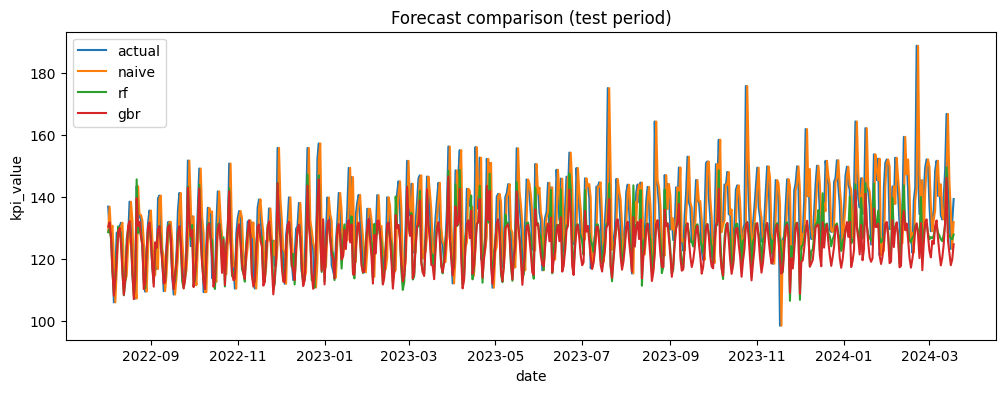

In [6]:
plt.figure(figsize=(12,4))
plt.plot(test["date"], y_test.values, label="actual")
plt.plot(test["date"], y_pred_naive, label="naive")
plt.plot(test["date"], y_pred_rf, label="rf")
plt.plot(test["date"], y_pred_gbr, label="gbr")
plt.title("Forecast comparison (test period)")
plt.xlabel("date")
plt.ylabel("kpi_value")
plt.legend()
plt.show()

## Save predictions for anomaly notebook

In [7]:
pred_df = test[["date"]].copy()
pred_df["y_true"] = y_test.values
pred_df["y_pred_naive"] = y_pred_naive
pred_df["y_pred_rf"] = y_pred_rf
pred_df["y_pred_gbr"] = y_pred_gbr

OUT_PATH = "../data/forecast_predictions.parquet"
pred_df.to_parquet(OUT_PATH, index=False)
print("Saved:", OUT_PATH)

Saved: ../data/forecast_predictions.parquet
